In [1]:
import pandas as pd
import numpy as np
from arch import arch_model
import matplotlib.pyplot as plt
from statsmodels.tsa.vector_ar.var_model import VARProcess

In [2]:
sp500_df = pd.read_csv('data/sp500_90.csv', index_col=0, parse_dates=True)

In [3]:
tarch_model = arch_model(sp500_df['sp500']*100, p=1, o=1, q=1).fit(disp='off')
print(tarch_model.summary())

                   Constant Mean - GJR-GARCH Model Results                    
Dep. Variable:                  sp500   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                  GJR-GARCH   Log-Likelihood:               -11543.3
Distribution:                  Normal   AIC:                           23096.6
Method:            Maximum Likelihood   BIC:                           23132.0
                                        No. Observations:                 8817
Date:                Sat, Feb 21 2026   Df Residuals:                     8816
Time:                        19:38:37   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0409  8.248e-03      4.958  7.113e-07 [2.

In [4]:
params = tarch_model.params
mu = params.get('mu', 0.0)
omega = params['omega']
alpha = params['alpha[1]']
gamma = params['gamma[1]']
beta = params['beta[1]']

last_r = sp500_df['sp500'].iloc[-1] * 100
last_h = tarch_model.conditional_volatility.iloc[-1] ** 2
eps_t = last_r - mu

simulated_returns = []
for day in range(30):
    h_next = omega + alpha * eps_t**2 + gamma * (eps_t < 0) * eps_t**2 + beta * last_h
    z_t = np.random.normal(0, 1)
    r_next = mu + np.sqrt(h_next) * z_t
    simulated_returns.append(r_next)
    eps_t = r_next - mu
    last_h = h_next

cumulative_return_30d = float(np.sum(simulated_returns))
print(f"30-day cumulative return (percent): {cumulative_return_30d:.4f}")

30-day cumulative return (percent): 8.0077


In [5]:
def simulate_tarch_path(model, days=30, simulations=2000):
    params = model.params
    mu = params.get('mu', 0.0)
    omega = params['omega']
    alpha = params['alpha[1]']
    gamma = params['gamma[1]']
    beta = params['beta[1]']

    last_r = sp500_df['sp500'].iloc[-1] * 100
    last_h = tarch_model.conditional_volatility.iloc[-1] ** 2
    eps_t = last_r - mu

    all_simulated_returns = []
    for sim in range(simulations):
        simulated_returns = []
        for day in range(days):
            h_next = omega + alpha * eps_t**2 + gamma * (eps_t < 0) * eps_t**2 + beta * last_h
            z_t = np.random.normal(0, 1)
            r_next = mu + np.sqrt(h_next) * z_t
            simulated_returns.append(r_next)
            eps_t = r_next - mu
            last_h = h_next
        all_simulated_returns.append(simulated_returns)
    
    return np.array(all_simulated_returns)

In [6]:
all_simulated_returns = simulate_tarch_path(tarch_model, days=30, simulations=2000)

In [ ]:
# cumulative_returns_30d = all_simulated_returns.sum(axis=1)
# fig, ax = plt.subplots(figsize=(12, 7))
# ax.hist(cumulative_returns_30d, bins=50, density=True, alpha=0.7, color='steelblue', edgecolor='black', linewidth=0.5)
# ax.axvline(cumulative_returns_30d.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {cumulative_returns_30d.mean():.2f}%')
# ax.axvline(np.percentile(cumulative_returns_30d, 5), color='orange', linestyle='--', linewidth=2, label=f'5th percentile: {np.percentile(cumulative_returns_30d, 5):.2f}%')
# ax.axvline(np.percentile(cumulative_returns_30d, 95), color='green', linestyle='--', linewidth=2, label=f'95th percentile: {np.percentile(cumulative_returns_30d, 95):.2f}%')
# ax.set_xlabel('Cumulative Return (%)', fontsize=12, fontweight='bold')
# ax.set_ylabel('Density', fontsize=12, fontweight='bold')
# ax.set_title('Distribution of Simulated 30-Day Cumulative Returns (TARCH Model)', fontsize=14, fontweight='bold')
# ax.legend(loc='upper right', fontsize=10)
# ax.grid(True, alpha=0.3, linestyle='--')
# plt.tight_layout()
# plt.show()

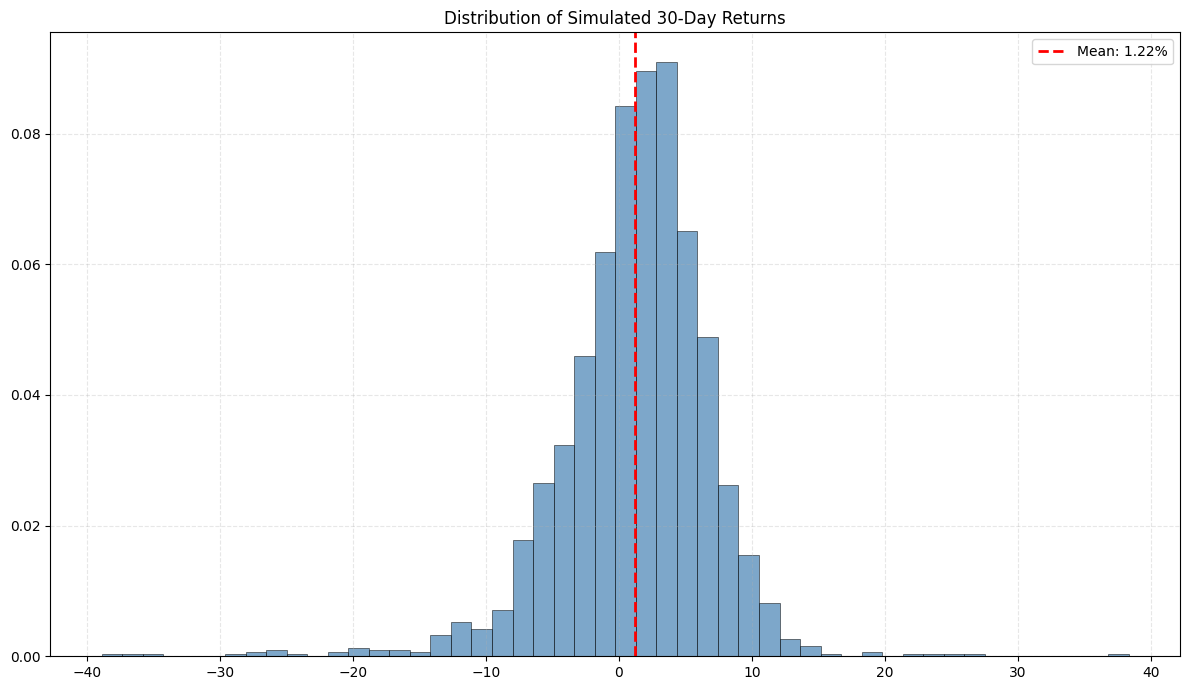

In [7]:
cumulative_return_30d = all_simulated_returns.sum(axis=1)
fig, ax = plt.subplots(figsize=(12, 7))
ax.hist(cumulative_return_30d, bins=50, density=True, alpha=0.7, color='steelblue', edgecolor='black', linewidth=0.5)
ax.axvline(cumulative_return_30d.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {cumulative_return_30d.mean():.2f}%')
ax.set_title('Distribution of Simulated 30-Day Returns')
ax.legend(loc='upper right', fontsize=10)
ax.grid(True, alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()


In [8]:
def simulate_tarch_path_empirical(model, days=30, simulations=2000):
    params = model.params
    mu = params.get("mu", 0.0)
    omega = params["omega"]
    alpha = params["alpha[1]"]
    gamma = params["gamma[1]"]
    beta = params["beta[1]"]

    z_emp = (model.resid / model.conditional_volatility).dropna().values
    last_r_base = sp500_df["sp500"].iloc[-1] * 100
    last_h_base = model.conditional_volatility.iloc[-1] ** 2

    all_simulated_returns = []
    for _ in range(simulations):
        eps_t = last_r_base - mu
        last_h = last_h_base

        simulated_returns = []
        for _ in range(days):
            h_next = omega + alpha * eps_t**2 + gamma * (eps_t < 0) * eps_t**2 + beta * last_h
            z_t = np.random.choice(z_emp)
            r_next = mu + np.sqrt(h_next) * z_t
            simulated_returns.append(r_next)
            eps_t = r_next - mu
            last_h = h_next

        all_simulated_returns.append(simulated_returns)

    return np.array(all_simulated_returns)

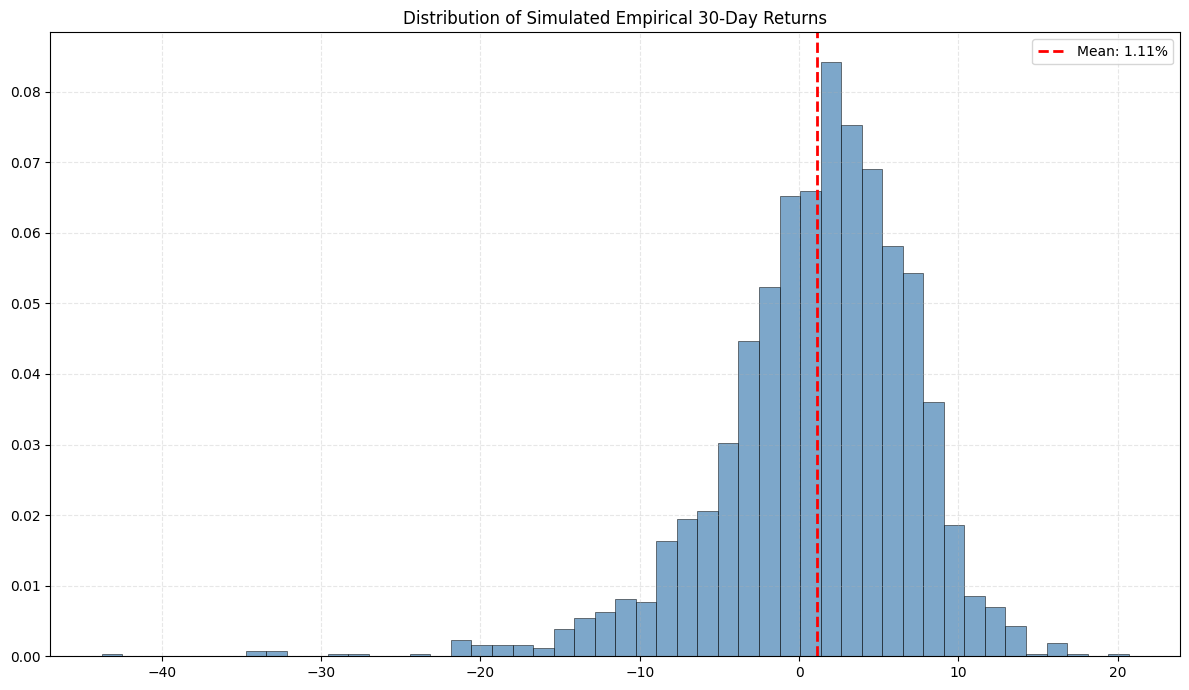

In [9]:
all_simulated_returns_empirical = simulate_tarch_path_empirical(tarch_model, days=30, simulations=2000)
cumulative_return_30d_empirical = all_simulated_returns_empirical.sum(axis=1)
fig, ax = plt.subplots(figsize=(12, 7))
ax.hist(cumulative_return_30d_empirical, bins=50, density=True, alpha=0.7, color='steelblue', edgecolor='black', linewidth=0.5)
ax.axvline(cumulative_return_30d_empirical.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {cumulative_return_30d_empirical.mean():.2f}%')
ax.set_title('Distribution of Simulated Empirical 30-Day Returns')
ax.legend(loc='upper right', fontsize=10)
ax.grid(True, alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

In [10]:
kurtosis = pd.Series(cumulative_return_30d).kurtosis()
print(f"Kurtosis of 30-day cumulative returns (empirical): {kurtosis:.4f}")
kurtosis_empirical = pd.Series(cumulative_return_30d_empirical).kurtosis()
print(f"Kurtosis of 30-day cumulative returns (empirical): {kurtosis_empirical:.4f}")
skewness = pd.Series(cumulative_return_30d).skew()
print(f"Skewness of 30-day cumulative returns (empirical): {skewness:.4f}")
skewness_empirical = pd.Series(cumulative_return_30d_empirical).skew()
print(f"Skewness of 30-day cumulative returns (empirical): {skewness_empirical:.4f}")

Kurtosis of 30-day cumulative returns (empirical): 6.7326
Kurtosis of 30-day cumulative returns (empirical): 4.2940
Skewness of 30-day cumulative returns (empirical): -0.9896
Skewness of 30-day cumulative returns (empirical): -1.2158


In [11]:
VaR = np.percentile(cumulative_return_30d, 1)
print(f"1% VaR of 30-day cumulative returns (empirical): {VaR:.4f}%")
VaR_empirical = np.percentile(cumulative_return_30d_empirical, 1)
print(f"1% VaR of 30-day cumulative returns (empirical): {VaR_empirical:.4f}%")

1% VaR of 30-day cumulative returns (empirical): -16.2309%
1% VaR of 30-day cumulative returns (empirical): -18.8603%


In [12]:
prob_fall_15 = np.mean(cumulative_return_30d < -15) 
print(f"Probability that put option (strike -15%) is in the money (normal): {prob_fall_15:.4f}")

prob_fall_15_empirical = np.mean(cumulative_return_30d_empirical < -15)
print(f"Probability that put option (strike -15%) is in the money (empirical): {prob_fall_15_empirical:.4f}")

Probability that put option (strike -15%) is in the money (normal): 0.0115
Probability that put option (strike -15%) is in the money (empirical): 0.0170


In [13]:
prob_rise_15 = np.mean(cumulative_return_30d > 15) 
print(f"Probability that call option (strike +15%) is in the money (normal): {prob_rise_15:.4f}")

prob_rise_15_empirical = np.mean(cumulative_return_30d_empirical > 15)
print(f"Probability that call option (strike +15%) is in the money (empirical): {prob_rise_15_empirical:.4f}")

Probability that call option (strike +15%) is in the money (normal): 0.0045
Probability that call option (strike +15%) is in the money (empirical): 0.0035


The put option should be more valuable as it has a higher probability of being ITM

In [14]:
# VAR(1): z_t = A z_{t-1} + e_t,  e_t ~ N(0, Omega)
A = np.array([[[0.8, -0.1],
              [-0.1, 0.7]]])
Omega = np.array([[9.0, 2.0],
                  [2.0, 4.0]])

In [23]:
coefs_exog = np.empty((0, A.shape[0]))       
VAR_process = VARProcess(coefs=A, coefs_exog=coefs_exog, sigma_u=Omega)

In [24]:
eigvals = np.linalg.eigvals(A)
print("Eigenvalues of A:", eigvals)
print("Stationary?", np.all(np.abs(eigvals) < 1), "(all |lambda|<1)")

Eigenvalues of A: [[0.8618034 0.6381966]]
Stationary? True (all |lambda|<1)


In [25]:
H_ma = 50
Psi = VAR_process.ma_rep(maxn=H_ma)
print("Psi_0:\n", Psi[0])
print("Psi_1:\n", Psi[1])
print("Psi_2:\n", Psi[2])
print("Psi_50:\n", Psi[50])

Psi_0:
 [[1. 0.]
 [0. 1.]]
Psi_1:
 [[ 0.8 -0.1]
 [-0.1  0.7]]
Psi_2:
 [[ 0.65 -0.15]
 [-0.15  0.5 ]]
Psi_50:
 [[ 0.00042649 -0.00026359]
 [-0.00026359  0.00016291]]


In [26]:
H = 15
Psi_15 = VAR_process.ma_rep(maxn=H) 
shock_sd = np.sqrt(np.diag(Omega)) 

In [27]:
irf = Psi_15 * shock_sd.reshape(1, 1, -1)

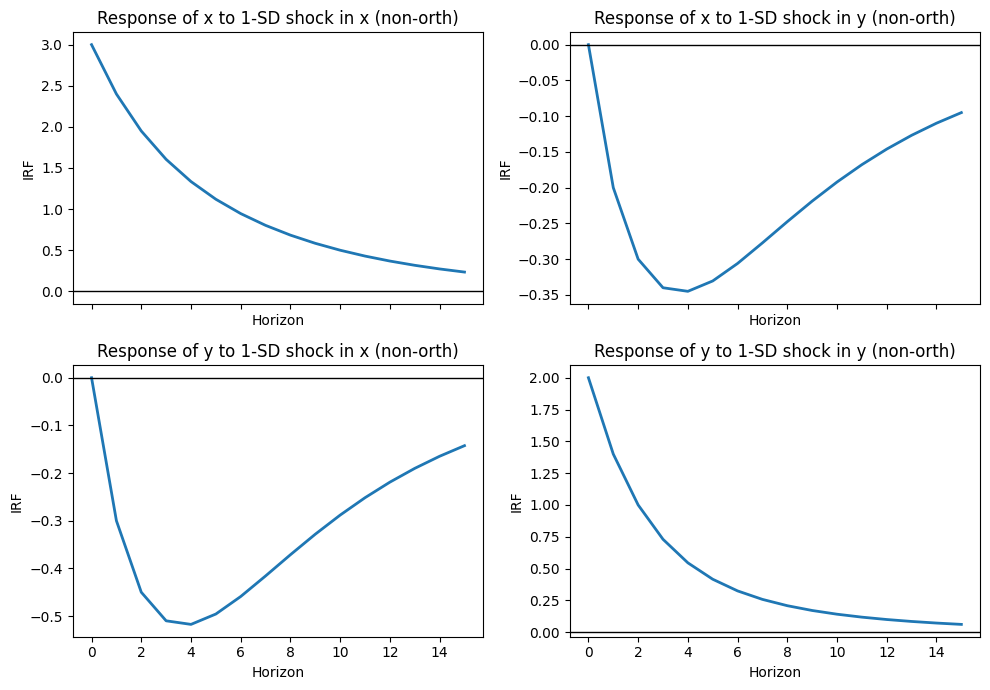

In [28]:
var_names = ["x", "y"]
fig, axes = plt.subplots(2, 2, figsize=(10, 7), sharex=True)
h = np.arange(H + 1)

for i in range(2):          
    for j in range(2):     
        ax = axes[i, j]
        ax.plot(h, irf[:, i, j], lw=2)
        ax.axhline(0, color="black", lw=1)
        ax.set_title(f"Response of {var_names[i]} to 1-SD shock in {var_names[j]} (non-orth)")
        ax.set_xlabel("Horizon")
        ax.set_ylabel("IRF")

plt.tight_layout()
plt.show()

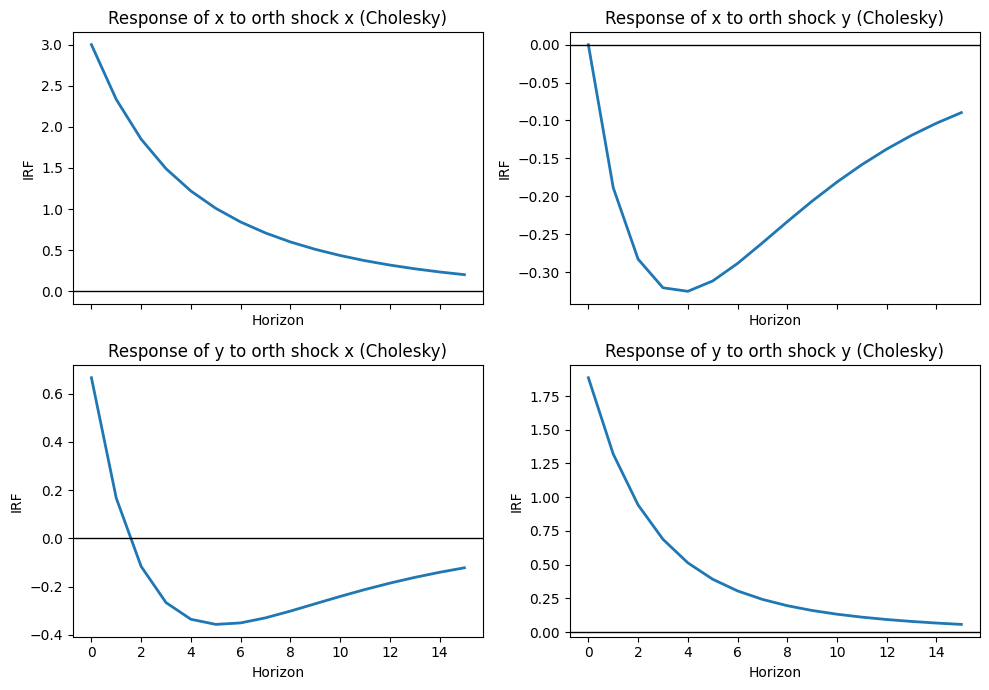

In [29]:
orth = VAR_process.orth_ma_rep(maxn=H)

fig, axes = plt.subplots(2, 2, figsize=(10, 7), sharex=True)
for i in range(2):
    for j in range(2):
        ax = axes[i, j]
        ax.plot(h, orth[:, i, j], lw=2)
        ax.axhline(0, color="black", lw=1)
        ax.set_title(f"Response of {var_names[i]} to orth shock {var_names[j]} (Cholesky)")
        ax.set_xlabel("Horizon")
        ax.set_ylabel("IRF")

plt.tight_layout()
plt.show()